[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/maurice1979/da-rnn/blob/master/DA-RNN.ipynb)

PyTorch Implementation of "A Dual-Stage Attention-Based Recurrent Neural Network for Time Series Prediction" paper, DA-RNN (arXiv:1704.02971) https://arxiv.org/pdf/1704.02971.pdf

There are two important concepts in the DA-RNN model. The first one is the popular Recursive Neural Network model, which has enjoyed big success in the NLP area. On a high level, RNN models are powerful to exhibit quite sophisticated dynamic temporal structure for sequential data. RNN models come in many forms, one of which is the Long-Short Term Memory(LSTM) model that is widely applied in language models. The second concept is the Attention Mechanism. Attention mechanism somewhat performs feature selection in a dynamic way, so that the model can keep only the most useful information at each temporal stage. Many successful deep learning models nowadays combine attention mechanism with RNN, with examples including machine translation.

The DA-RNN model, on the high level, includes two LSTM networks with attention mechanism. The first LSTM network encodes information among historical exogenous data, and its attention mechanism performs feature selection to select the most important exogenous factors. Based on the output of the first LSTM network, the second LSTM network further combines the information from exogenous data with the historical target time series. The attention mechanism in the second network performs feature selection in the time domain, i.e., it applies weights to information at different historical time points. The final prediction, therefore, is based on feature selection in both the dimension of exogenous factors and time. Unlike classical feature selection in statistical models, DA-RNN selects features dynamically. In other words, the weights on factors and time points are changing across time. One inaccurate analogy, perhaps, is a regression model with ARMA errors, with time-varying coefficients for both the exogenous factors and the ARMA terms.

Based on https://github.com/Zhenye-Na/DA-RNN repository

# Imports

In [16]:
import typing
from typing import Tuple
import json
import os
from pathlib import Path

import torch
from torch import nn
from torch import optim
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import utils
from modules import Encoder, Decoder
from custom_types import DaRnnNet, TrainData, TrainConfig
from utils import numpy_to_tvar
from constants import device

In [39]:
# Allow to zoom into graphs

#! pip install mpld3
import mpld3

mpld3.enable_notebook()

In [5]:
logger = utils.setup_log()
logger.info(f"Using computation device: {device}")

2020-04-04 18:29:51,195 - VOC_TOPICS - INFO - Using computation device: cpu


# Functions

## Preprocess data

In [ ]:
def preprocess_data(data: pd.DataFrame, col_names: list) -> Tuple[TrainData, StandardScaler]:
    """Preprocess data to train the model.
    
    Parameters
    ----------
    
    data: Data to be used in the training
    col_names: List of target column names
    
    """
    scale = StandardScaler().fit(data)
    proc_data = scale.transform(data)

    mask = np.ones(proc_data.shape[1], dtype=bool)
    data_cols = list(data.columns)
    for col_name in col_names:
        mask[data_cols.index(col_name)] = False

    feats = proc_data[:, mask]
    targs = proc_data[:, ~mask]

    return TrainData(feats, targs), scale

## Define Architecture

In [ ]:
def da_rnn(train_data: TrainData, n_targs: int, encoder_hidden_size=64,
           decoder_hidden_size=64, T=10, learning_rate=0.01, batch_size=128):
    """da_rnn."""
    train_cfg = TrainConfig(T, int(train_data.feats.shape[0] * 0.7),
                            batch_size, nn.MSELoss())
    logger.info(f'Training size: {train_cfg.train_size:d}.')

    enc_kwargs = {
        'input_size': train_data.feats.shape[1],
        'hidden_size': encoder_hidden_size,
        'T': T
    }
    encoder = Encoder(**enc_kwargs).to(device)
    with open(os.path.join(data / 'enc_kwargs.json'), 'w') as fi:
        json.dump(enc_kwargs, fi, indent=4)

    dec_kwargs = {
        'encoder_hidden_size': encoder_hidden_size,
        'decoder_hidden_size': decoder_hidden_size,
        'T': T,
        'out_feats': n_targs
    }
    decoder = Decoder(**dec_kwargs).to(device)
    with open(os.path.join(data / 'dec_kwargs.json'), 'w') as fi:
        json.dump(dec_kwargs, fi, indent=4)

    encoder_optimizer = optim.Adam(
        params=[p for p in encoder.parameters() if p.requires_grad],
        lr=learning_rate)
    decoder_optimizer = optim.Adam(
        params=[p for p in decoder.parameters() if p.requires_grad],
        lr=learning_rate)
    da_rnn_net = DaRnnNet(
        encoder,
        decoder,
        encoder_optimizer,
        decoder_optimizer
    )

    return train_cfg, da_rnn_net

## Train

In [ ]:
def train(net: DaRnnNet, train_data: TrainData, t_cfg: TrainConfig,
          n_epochs=10, save_plots=False):
    """train."""
    iter_per_epoch = int(np.ceil(t_cfg.train_size * 1. / t_cfg.batch_size))
    iter_losses = np.zeros(n_epochs * iter_per_epoch)
    epoch_losses = np.zeros(n_epochs)
    logger.info(
        f'Iterations per epoch: '
        f'{t_cfg.train_size * 1. / t_cfg.batch_size:3.3f}'
        f' ~ {iter_per_epoch:d}.'
    )

    n_iter = 0

    for e_i in range(n_epochs):
        perm_idx = np.random.permutation(t_cfg.train_size - t_cfg.T)

        for t_i in range(0, t_cfg.train_size, t_cfg.batch_size):
            batch_idx = perm_idx[t_i:(t_i + t_cfg.batch_size)]
            feats, y_history, y_target = prep_train_data(
                batch_idx,
                t_cfg,
                train_data
            )

            loss = train_iteration(
                net,
                t_cfg.loss_func,
                feats,
                y_history,
                y_target
            )
            iter_losses[e_i * iter_per_epoch + t_i // t_cfg.batch_size] = loss
            # if (j / t_cfg.batch_size) % 50 == 0:
            #    self.logger.info("Epoch %d, Batch %d: loss = %3.3f.", i, j / t_cfg.batch_size, loss)
            n_iter += 1

            adjust_learning_rate(net, n_iter)

        epoch_losses[e_i] = np.mean(
            iter_losses[range(e_i * iter_per_epoch, (e_i + 1) * iter_per_epoch)]
        )

        if e_i % 10 == 0:
            y_test_pred = predict(net, train_data,
                                  t_cfg.train_size, t_cfg.batch_size, t_cfg.T,
                                  on_train=False)
            # TODO: make this MSE and make it work for multiple inputs
            val_loss = y_test_pred - train_data.targs[t_cfg.train_size:]
            logger.info(
                f'Epoch {e_i:d}, train loss: {epoch_losses[e_i]:3.3f}, '
                f'val loss: {np.mean(np.abs(val_loss))}.'
            )
            y_train_pred = predict(
                net,
                train_data,
                t_cfg.train_size,
                t_cfg.batch_size,
                t_cfg.T,
                on_train=True
            )
            plt.figure()
            plt.plot(range(1, 1 + len(train_data.targs)), train_data.targs,
                     label="True")
            plt.plot(range(t_cfg.T, len(y_train_pred) + t_cfg.T), y_train_pred,
                     label='Predicted - Train')
            plt.plot(range(t_cfg.T + len(y_train_pred),
                     len(train_data.targs) + 1),
                     y_test_pred,
                     label='Predicted - Test')
            plt.legend(loc='upper left')
            utils.save_or_show_plot(f"pred_{e_i}.png", save_plots)

    return iter_losses, epoch_losses

## Prepare training data

In [ ]:
def prep_train_data(batch_idx: np.ndarray, t_cfg: TrainConfig,
                    train_data: TrainData):
    """prep_train_data."""
    feats = np.zeros((len(batch_idx), t_cfg.T - 1, train_data.feats.shape[1]))
    y_history = np.zeros(
        (len(batch_idx), t_cfg.T - 1, train_data.targs.shape[1])
    )
    y_target = train_data.targs[batch_idx + t_cfg.T]

    for b_i, b_idx in enumerate(batch_idx):
        b_slc = slice(b_idx, b_idx + t_cfg.T - 1)
        feats[b_i, :, :] = train_data.feats[b_slc, :]
        y_history[b_i, :] = train_data.targs[b_slc]

    return feats, y_history, y_target

## Adjust learning rate

In [ ]:
def adjust_learning_rate(net: DaRnnNet, n_iter: int):
    """adjust_learning_rate."""
    # TODO: Where did this Learning Rate adjustment schedule come from?
    # Should be modified to use Cosine Annealing with warm restarts
    # https://www.jeremyjordan.me/nn-learning-rate/
    if n_iter % 10000 == 0 and n_iter > 0:
        for enc_params, dec_params in zip(net.enc_opt.param_groups,
                                          net.dec_opt.param_groups):
            enc_params['lr'] = enc_params['lr'] * 0.9
            dec_params['lr'] = dec_params['lr'] * 0.9

## Train iteration

In [6]:
def train_iteration(t_net: DaRnnNet, loss_func: typing.Callable, X, y_history,
                    y_target):
    t_net.enc_opt.zero_grad()
    t_net.dec_opt.zero_grad()

    input_weighted, input_encoded = t_net.encoder(numpy_to_tvar(X))
    y_pred = t_net.decoder(input_encoded, numpy_to_tvar(y_history))

    y_true = numpy_to_tvar(y_target)
    loss = loss_func(y_pred, y_true)
    loss.backward()

    t_net.enc_opt.step()
    t_net.dec_opt.step()

    return loss.item()

## Predict

In [ ]:
def predict(t_net: DaRnnNet, t_dat: TrainData, train_size: int,
            batch_size: int, T: int, on_train=False):
    out_size = t_dat.targs.shape[1]
    if on_train:
        y_pred = np.zeros((train_size - T + 1, out_size))
    else:
        y_pred = np.zeros((t_dat.feats.shape[0] - train_size, out_size))

    for y_i in range(0, len(y_pred), batch_size):
        y_slc = slice(y_i, y_i + batch_size)
        batch_idx = range(len(y_pred))[y_slc]
        b_len = len(batch_idx)
        X = np.zeros((b_len, T - 1, t_dat.feats.shape[1]))
        y_history = np.zeros((b_len, T - 1, t_dat.targs.shape[1]))

        for b_i, b_idx in enumerate(batch_idx):
            if on_train:
                idx = range(b_idx, b_idx + T - 1)
            else:
                idx = range(b_idx + train_size - T, b_idx + train_size - 1)

            X[b_i, :, :] = t_dat.feats[idx, :]
            y_history[b_i, :] = t_dat.targs[idx]

        y_history = numpy_to_tvar(y_history)
        _, input_encoded = t_net.encoder(numpy_to_tvar(X))
        y_pred[y_slc] = t_net.decoder(
            input_encoded,
            y_history
        ).cpu().data.numpy()

    return y_pred

# Calculations

In [7]:
save_plots = True
debug = False

In [8]:
data_path = Path('data')
filename = 'nasdaq100_padding.csv' 

In [14]:
raw_data = pd.read_csv(data_path / filename,
                       nrows=100 if debug else None)
logger.info(f'Shape of data: {raw_data.shape}; Missing in data: '
            f'{raw_data.isnull().sum().sum()}')

2020-04-04 18:31:42,571 - VOC_TOPICS - INFO - Shape of data: (40560, 82); Missing in data: 0


Preprocess the data:

In [19]:
targ_cols = ("NDX",)
data, scaler = preprocess_data(raw_data, targ_cols)

In [20]:
da_rnn_kwargs = {"batch_size": 128, "T": 10}

Instantiate model

In [21]:
config, model = da_rnn(
    data,
    n_targs=len(targ_cols),
    learning_rate=.001,
    **da_rnn_kwargs)

2020-04-04 18:37:24,212 - VOC_TOPICS - INFO - Training size: 28392.


In [23]:
config

TrainConfig(T=10, train_size=28392, batch_size=128, loss_func=MSELoss())

In [22]:
model

DaRnnNet(encoder=Encoder(
  (lstm_layer): LSTM(81, 64)
  (attn_linear): Linear(in_features=137, out_features=1, bias=True)
), decoder=Decoder(
  (attn_layer): Sequential(
    (0): Linear(in_features=192, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (lstm_layer): LSTM(1, 64)
  (fc): Linear(in_features=65, out_features=1, bias=True)
  (fc_final): Linear(in_features=128, out_features=1, bias=True)
), enc_opt=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), dec_opt=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
))

## Train the model

2020-04-05 08:15:23,371 - VOC_TOPICS - INFO - Iterations per epoch: 221.812 ~ 222.
2020-04-05 08:16:04,694 - VOC_TOPICS - INFO - Epoch 0, train loss: 0.002, val loss: 0.09039550655008204.
2020-04-05 08:22:28,765 - VOC_TOPICS - INFO - Epoch 10, train loss: 0.001, val loss: 0.05109339872644948.
2020-04-05 08:28:56,322 - VOC_TOPICS - INFO - Epoch 20, train loss: 0.001, val loss: 0.052669071197407734.
2020-04-05 08:35:15,223 - VOC_TOPICS - INFO - Epoch 30, train loss: 0.001, val loss: 0.05863786913571264.
2020-04-05 08:41:10,885 - VOC_TOPICS - INFO - Epoch 40, train loss: 0.001, val loss: 0.057008714322335986.
2020-04-05 08:47:22,689 - VOC_TOPICS - INFO - Epoch 50, train loss: 0.001, val loss: 0.05622067887186887.
2020-04-05 08:53:44,471 - VOC_TOPICS - INFO - Epoch 60, train loss: 0.001, val loss: 0.042437158011103836.
2020-04-05 08:59:31,879 - VOC_TOPICS - INFO - Epoch 70, train loss: 0.001, val loss: 0.04952791943204267.
2020-04-05 09:05:35,771 - VOC_TOPICS - INFO - Epoch 80, train loss:

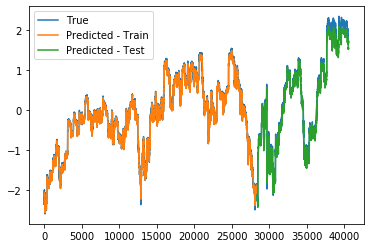

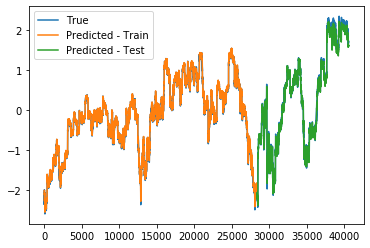

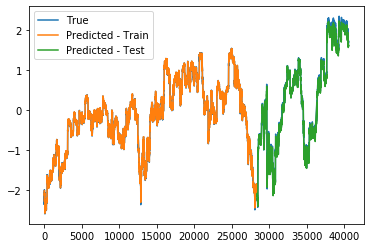

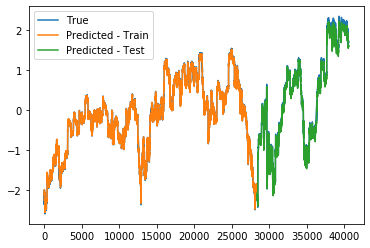

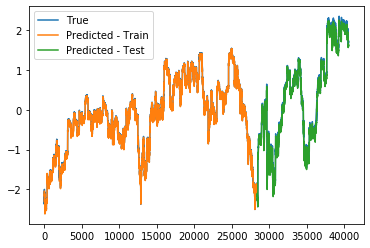

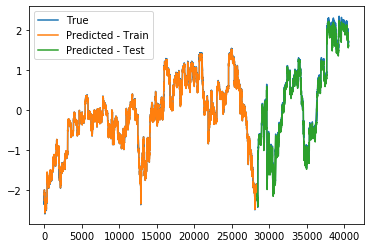

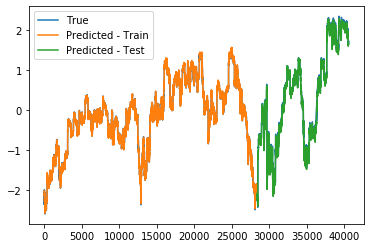

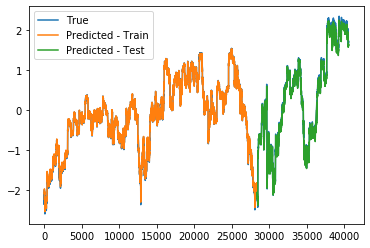

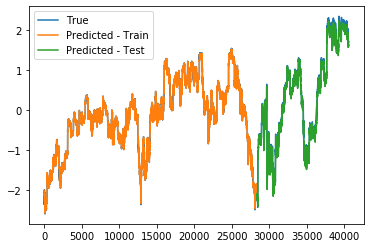

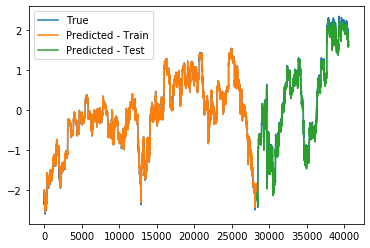

In [35]:
iter_loss, epoch_loss = train(
    model,
    data,
    config,
    n_epochs=100, # 10
    save_plots=save_plots
)

## Predict

In [42]:
final_y_pred = predict(
    model,
    data,
    config.train_size,
    config.batch_size,
    config.T
)

# Results

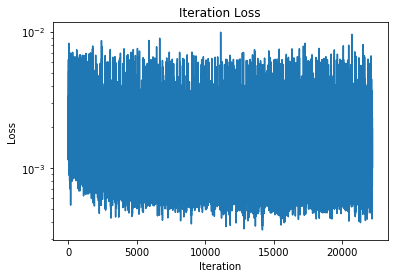

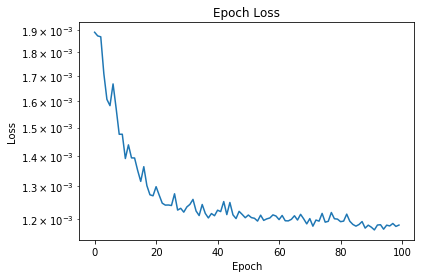

In [40]:
plt.figure()
plt.title('Iteration Loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.semilogy(range(len(iter_loss)), iter_loss)
utils.save_or_show_plot("iter_loss.png", save_plots)

plt.figure()
plt.title('Epoch Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.semilogy(range(len(epoch_loss)), epoch_loss)
utils.save_or_show_plot("epoch_loss.png", save_plots)

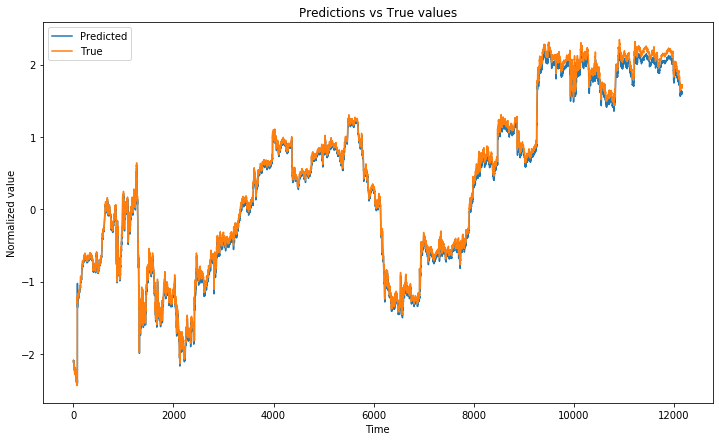

In [49]:
plt.figure(figsize=(12, 7))
plt.title('Predictions vs True values')
plt.ylabel('Normalized value')
plt.xlabel('Time')
plt.plot(final_y_pred, label='Predicted')
plt.plot(data.targs[config.train_size:], label="True")
plt.legend(loc='upper left')
utils.save_or_show_plot("final_predicted.png", save_plots)

In [52]:
with open(data_path / 'da_rnn_kwargs.json', 'w') as fi:
    json.dump(da_rnn_kwargs, fi, indent=4)

In [55]:
joblib.dump(scaler, data_path / 'scaler.pkl')
torch.save(model.encoder.state_dict(), data_path / 'encoder.torch')
torch.save(model.decoder.state_dict(), data_path / 'decoder.torch')

# References

* https://chandlerzuo.github.io/blog/2017/11/darnn
* https://github.com/Zhenye-Na/DA-RNN
* This repository is forked from https://github.com/jsyzeng/da-rnn